# Домашнее задание №6. Реранжирование в рекомендациях с помощью GDBT

In [1]:
!pip -q install lightfm
!pip -q install rectools
!pip -q install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import gc
import json
import pickle

import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import requests
import shap

from lightfm import LightFM
from lightfm.data import Dataset
from lightgbm import LGBMRanker, LGBMClassifier
from rectools.models import LightFMWrapperModel, PopularModel
from rectools.metrics import calc_metrics, NDCG, MAP, Precision, Recall, MeanInvUserFreq
from rectools import Columns
from rectools.dataset import Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from typing import Any, Dict, Tuple
from tqdm.auto import tqdm

from utils.tools import generate_lightfm_recs_mapper, avg_user_metric

## Подготовка данных

In [ ]:
DATA_PATH = "/content/drive/MyDrive/recsys_course/data_kion"
users = pd.read_csv(f'{DATA_PATH}/users.csv')
items = pd.read_csv(f'{DATA_PATH}/items.csv')
interactions = pd.read_csv(f'{DATA_PATH}/interactions.csv')

### `interactions`: взаимодействия пользователь - айтем
- с датой `last_watch_dt`
- длительностью просмотра `total_dur`
- % просмотра `watched_pct`

In [ ]:
print(interactions.shape)
interactions.head(3)

(5476251, 5)


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0


In [ ]:
# Меняем названия колонок для использования rectools
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
        'watched_pct': Columns.Weight,
    },
    inplace=True,
)
# Меняем тип данных
interactions['datetime'] = interactions['datetime'].astype(np.datetime64)

# Заполняем пропуски
interactions_default_values: Dict[str, Any] = {
   Columns.Datetime: interactions[Columns.Datetime].median(),
    Columns.Weight: 0.,
    'total_dur': 0,
}
interactions.fillna(interactions_default_values, inplace=True)

# Смотрим что получилось
interactions.head(10)

,user_id,item_id,datetime,total_dur,weight
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5,1032142,6686,2021-05-13,11286,100.0
6,1016458,354,2021-08-14,1672,25.0
7,884009,693,2021-08-04,703,14.0
8,648682,1449,2021-06-13,26246,75.0
9,203219,13582,2021-08-22,6975,100.0


In [ ]:
interactions.describe(datetime_is_numeric=True)

,user_id,item_id,datetime,total_dur,weight
count,5.476251e+06,5.476251e+06,5476251,5.476251e+06,5.476251e+06
mean,5.491159e+05,8.485860e+03,2021-06-23 11:56:04.296268032,8.295490e+03,4.636699e+01
min,0.000000e+00,0.000000e+00,2021-03-13 00:00:00,1.000000e+00,0.000000e+00
25%,2.750140e+05,4.326000e+03,2021-05-25 00:00:00,3.710000e+02,4.000000e+00
50%,5.493640e+05,8.776000e+03,2021-07-01 00:00:00,2.898000e+03,3.200000e+01
75%,8.227540e+05,1.254400e+04,2021-07-30 00:00:00,7.116000e+03,1.000000e+02
max,1.097557e+06,1.651800e+04,2021-08-22 00:00:00,8.041167e+07,1.000000e+02
std,3.166077e+05,4.740762e+03,NaN,4.856799e+04,4.191923e+01


### `users`: данные о пользователях

- `age` бин по возрасту
- `income` бин по доходу
- `sex` пол
- `kids_flg` флаг наличия детей

Все признаки - результат предсказания соцдем моделей

In [ ]:
print(users.shape)
users.head(3)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0


In [ ]:
def encode_cat_cols(df: pd.DataFrame, cat_cols) -> Tuple[pd.DataFrame, Dict]:
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

users_cat_cols = [
    # 'user_id',
     'age', 'income', 'sex', 'kids_flg'
]
users, users_cat_col_encoding = encode_cat_cols(users, users_cat_cols)

# None уже кодируется как -1
users_cat_col_encoding['income'], users['income'].unique()

(Index(['income_0_20', 'income_150_inf', 'income_20_40', 'income_40_60',
        'income_60_90', 'income_90_150'],
       dtype='object'),
 [4, 2, 3, 0, -1, 5, 1]
 Categories (7, int64): [-1, 0, 1, 2, 3, 4, 5])

In [ ]:
users.head(3)

,user_id,age,income,sex,kids_flg
0,973171,1,4,1,1
1,962099,0,2,1,0
2,1047345,3,3,0,0


In [ ]:
# Наиболее популярны income - income_40_60
users.describe(include='category')

,age,income,sex,kids_flg
count,840197,840197,840197,840197
unique,7,7,3,2
top,1,2,0,0
freq,233926,471519,425270,587209


### `items`: данные об айтемах

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [ ]:
print(items.shape)
items.head(3)

(15963, 14)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [ ]:
# Аналогичным образом кодируем категориальные колонки и пока удаляем текстовые
items_cat_cols = [
    # 'item_id',
    'content_type', 'for_kids', 'studios',
]
items_text_cols = [
    'title', 'title_orig', 'genres', 'countries', 'directors', 'actors', 'description', 'keywords',
]
items_num_cols = [
    'release_year', 'age_rating',
]
default_values_items = {
    'release_year': items['release_year'].median(),
    'age_rating': items['age_rating'].median(),
}

items, items_cat_col_encoding = encode_cat_cols(items, items_cat_cols)
items = items.drop(items_text_cols, axis=1)
items.fillna(default_values_items, inplace=True)

items_cat_col_encoding['studios']

Index(['ABC', 'Amediateka', 'BBC', 'CBS', 'CBS All Access', 'Channel 4',
       'Cinemax', 'DAZN', 'Disney', 'Endemol', 'FX', 'Fox', 'Fremantle', 'HBO',
       'HBO Max', 'HBO, BBC', 'Legendary', 'MGM', 'New Regency Productions',
       'Paramount', 'Showtime', 'Sky', 'Sky, Fremantle', 'Sony Pictures',
       'Sony Pictures Television', 'Sony Pictures, рентв', 'Sony Plus',
       'Sony Plus, рентв', 'Starz', 'Universal', 'Universal, рентв',
       'Warner Bros', 'Warner Bros. Television', 'Ленфильм', 'Ленфильм, рентв',
       'Мосфильм', 'Рок фильм', 'рентв'],
      dtype='object')

In [ ]:
items.describe(include='all')

,item_id,content_type,release_year,for_kids,age_rating,studios
count,15963.000000,15963.0,15963.000000,15963.0,15963.000000,15963.0
unique,NaN,2.0,NaN,3.0,NaN,39.0
top,NaN,0.0,NaN,-1.0,NaN,-1.0
freq,NaN,12002.0,NaN,15397.0,NaN,14898.0
mean,8268.453424,NaN,2007.969492,NaN,12.945937,NaN
std,4773.841513,NaN,16.835890,NaN,5.495760,NaN
min,0.000000,NaN,1897.000000,NaN,0.000000,NaN
25%,4141.500000,NaN,2007.000000,NaN,12.000000,NaN
50%,8266.000000,NaN,2014.000000,NaN,16.000000,NaN
75%,12414.500000,NaN,2018.000000,NaN,16.000000,NaN


## Трейн-вал-тест сплит

In [ ]:
max_date = interactions[Columns.Datetime].max()
min_date = interactions[Columns.Datetime].min()

print(f'min дата в interactions: {min_date}')
print(f'max дата в interactions: {max_date}')
print(f'Продолжительность: {max_date - min_date}')

min дата в interactions: 2021-03-13 00:00:00
max дата в interactions: 2021-08-22 00:00:00
Продолжительность: 162 days 00:00:00


### Схема валидации с разбиением по юзерам

In [ ]:
# Обучать ранжирование будем на последнем месяце (30 дней) не считая отложенной недели
# Лучше зафиксировать временной диапазон если на проде планируется переобучать модель
ranker_days_count = 30

ranker_data = interactions[
    (interactions[Columns.Datetime] >= max_date - pd.Timedelta(days=ranker_days_count))
]

# В дальнейшем ranker_data разбиваем по юзерам
#  на train val test для обучения, валидации и тестирования ранкера
train_size = 0.7
val_size = 0.15
test_size = 0.15

# В train_test_split очень удобно можно сохранить исходное распределение по нужным факторам,
#  задав параметр stratify. Правда мы на это пока забьем)

train_val_users, test_users = train_test_split(
    ranker_data['user_id'].unique(), random_state=42, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=42, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

In [ ]:
# Для базовых моделей первого уровня
#  оставим все оставшиеся взаимодействия для обучения

base_models_data = interactions[
    (interactions[Columns.Datetime] < max_date - pd.Timedelta(days=ranker_days_count))
]

## Модели первого уровня

### LightFM

Выберем данную модель, тк она дала лучшую метрику на лидерборде в ходе прошлых дз.

Загрузим предсказания LightFM модели (обучение и сохранение кандидатов есть в ноутбуке hw_6_lightfm_training.ipynb)

In [ ]:
RECOS_PATH = "/content/drive/MyDrive/recsys_course/recommendations"

In [ ]:
lfm_candidates = pd.read_csv(f"{RECOS_PATH}/candidates_lightfm.csv")

In [ ]:
lfm_candidates.head()

,user_id,item_id,lfm_score,lfm_rank
0,176549,15297,-0.000603,1
1,176549,10440,-0.000603,2
2,176549,13865,-0.000604,3
3,176549,4151,-0.000604,4
4,176549,2657,-0.000604,5


### Popular model

In [ ]:
dataset = Dataset.construct(base_models_data)
popular_model = PopularModel()
popular_model.fit(dataset)

In [ ]:
n_items = 50
pop_candidates = popular_model.recommend(
    dataset.user_id_map.external_ids[:1], dataset, n_items, True
)
pop_candidates.rename({"rank": "pop_rank", "score": "pop_score"}, axis=1, inplace=True)
pop_candidates.drop(Columns.User, axis=1, inplace=True)
pop_candidates.head()

,item_id,pop_score,pop_rank
0,10440,141889.0,1
1,15297,137128.0,2
2,13865,93403.0,3
3,4151,69641.0,4
4,2657,55146.0,5


### Объединяем кандидатов из обеих моделей

In [ ]:
# делаем left join, чтобы не потерять кандидатов из LightFM
candidates = lfm_candidates.merge(pop_candidates, how="left", on=[Columns.Item])
candidates.head()

,user_id,item_id,lfm_score,lfm_rank,pop_score,pop_rank
0,176549,15297,-0.000603,1,137128.0,2.0
1,176549,10440,-0.000603,2,141889.0,1.0
2,176549,13865,-0.000604,3,93403.0,3.0
3,176549,4151,-0.000604,4,69641.0,4.0
4,176549,2657,-0.000604,5,55146.0,5.0


In [ ]:
# проверяем, что ничего не потеряли
assert len(candidates) == len(lfm_candidates)

In [ ]:
# удаляем лишнее, чтобы не забивать оперативную память
del lfm_candidates
gc.collect()
del pop_candidates
gc.collect()

0

## Считаем метрики моделей

In [4]:
# Считаем метрики
def calc_metrics_(candidates_df, rank_col: str) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            ranker_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [ranker_data[Columns.User].isin(test_users)]
        ),
        prev_interactions=(
            base_models_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_models_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

In [ ]:
models_metrics: Dict[str, Dict[str, float]] = dict()

In [ ]:
models_metrics['lfm'] = calc_metrics_(candidates, 'lfm_rank')
models_metrics['lfm']

{'Precision@10': 0.024622043497613315,
 'recall@10': 0.08233934647476762,
 'ndcg@10': 0.031615582594864314,
 'map@10': 0.042710384993952966,
 'novelty@10': 3.137157446579018}

In [ ]:
models_metrics["pop"] = calc_metrics_(candidates, "pop_rank")
models_metrics["pop"]

{'Precision@10': 0.01955397295596519,
 'recall@10': 0.06567592267978621,
 'ndcg@10': 0.02416983974819715,
 'map@10': 0.03136498967480883,
 'novelty@10': 3.1365885705885543}

## Формируем датасет для ранкера

### Генерим фичи для ранкера

In [ ]:
# Получаем длину истории юзера
base_models_data['user_hist'] = (
    base_models_data.groupby('user_id')
    ['item_id'].transform('count')
)

# Получаем популярность контента
base_models_data['item_pop'] = (
    base_models_data.groupby('item_id')
    ['user_id'].transform('count')
)

# Получаем среднюю популярность контента, просматриваемого этим юзером
base_models_data['user_avg_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('mean')
)

# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_models_data['item_avg_hist'] = (
    base_models_data.groupby('item_id')
    ['user_hist'].transform('mean')
)

# Получаем популярность последнего просмотренного контента
base_models_data.sort_values(
    by=[Columns.User, Columns.Datetime],
    ascending=[True, False],
    ignore_index=True,
    inplace=True,
)
base_models_data['user_last_pop'] = (
    base_models_data.groupby('user_id')
    ['item_pop'].transform('first')
)

# Получаем общее время просмотра для юзера
base_models_data["time_watched"] = (
    base_models_data["total_dur"] * base_models_data["weight"] / 100
)
base_models_data["user_watch_total_time"] = (
    base_models_data.groupby("user_id")["time_watched"].transform("sum")
)
base_models_data.drop("time_watched", axis=1, inplace=True)

base_models_data.head(3)

,user_id,item_id,datetime,total_dur,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop,user_watch_total_time
0,0,6006,2021-07-20,1,0.0,6,5208,41885.0,16.891897,5208,7.67
1,0,7102,2021-07-19,169,3.0,6,11626,41885.0,20.349475,5208,7.67
2,0,14359,2021-07-19,130,2.0,6,6053,41885.0,22.546836,5208,7.67


In [ ]:
# Добавляем новые фичи в соответствующие таблички
items = pd.merge(
    left=items,
    right=(
        base_models_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users,
    right=(
        base_models_data
        [[
            'user_id',
            'user_hist',
            'user_avg_pop',
            'user_last_pop',
            'user_watch_total_time'
        ]]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,user_watch_total_time
0,973171,1,4,1,1,5.0,19550.800000,93403.0,171398.16
1,962099,0,2,1,0,13.0,1329.307692,260.0,58671.26
2,1047345,3,3,0,0,NaN,NaN,NaN,NaN


In [ ]:
# Обновляем дефолтные значения
# Прямо сейчас обновлять таблички users и items не обязательно,
# сделаем это при джойне с кандидатами

# Для новых фичей айтемов
default_values_items['item_pop'] = base_models_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_models_data['item_avg_hist'].median()

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_models_data['user_avg_pop'].median(),
    'user_last_pop': base_models_data['user_last_pop'].median(),
    'user_watch_total_time': 0,
}

### Джойним кандидатов и юзер/айтем фичи

In [ ]:
# Вспоминаем про наши выборки интеракций для ранкера.
# Мы отобрали юзеров для обучения, валидации и теста.
# Оставляем среди них только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame,
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)],
        candidates_df[candidates_df['user_id'].isin(user_list)],
        how='right',
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    lfm_min_score: float =  df['lfm_score'].min() - 0.01
    lfm_max_rank: int = df['lfm_rank'].max() + 1  # 51
    pop_min_score: float =  df['pop_score'].min() - 0.01
    pop_max_rank: int = df['pop_rank'].max() + 1  # 101

    default_values = {
        'lfm_score': lfm_min_score,
        'lfm_rank': lfm_max_rank,
        'pop_score': pop_min_score,
        'pop_rank': pop_max_rank,
        # Важно использовате те же дефолтные значения для интеракций,
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)

    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, ranker_data)
ranker_val = users_filter(val_users, candidates, ranker_data)
ranker_test = users_filter(test_users, candidates, ranker_data)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank
5866543,3,101,2021-07-01,0.0,0.0,8.651793e-07,44,6862.99,51.0
5866506,3,142,2021-08-13,5892.0,100.0,1.606612e-06,7,35862.00,8.0
5866548,3,657,2021-07-01,0.0,0.0,8.317857e-07,49,7157.00,48.0


In [ ]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df,
        users,
        how='left',
        on=['user_id']
    )
    df = pd.merge(
        df,
        items,
        how='left',
        on=['item_id']
    )

    # При джойне могут получиться строки с несуществующими айтемами или юзерами.
    # Надо заполнить пропуски. Используем заготовленные дефолтные значения,
    # чтобы не сделать утечку
    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

# Не забываем добавить фичи в трейн, вал и тест
# Еще правильнее бы было сначала подготовить датасет,
# а потом его разбивать по юзерам - так бы мы избежали дублирования операций.
ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_avg_pop,user_last_pop,user_watch_total_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist
0,3,101,2021-07-01,0.0,0.0,8.651793e-07,44,6862.99,51.0,-1,...,11957.864865,2858.0,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673
1,3,142,2021-08-13,5892.0,100.0,1.606612e-06,7,35862.00,8.0,-1,...,11957.864865,2858.0,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464
2,3,657,2021-07-01,0.0,0.0,8.317857e-07,49,7157.00,48.0,-1,...,11957.864865,2858.0,0.0,0,2015.0,-1,18.0,-1,7157.0,23.835266


In [ ]:
del candidates
gc.collect()

3

In [ ]:
# Датасеты готовы, остались только таргеты,
# которые можно посчитать на основе колонок total_dur и watched_pct

# Делаем еще один чекпоинт.

# Не пользуемся методом eval если точно не знаем, что за строка.
# Он не безопасен и долго работает.
# Можно заменить на locals()[name]
for name in ['train', 'val', 'test']:
    path: str = f'/content/drive/MyDrive/recsys_course/ranker_{name}.csv'
    locals()[f'ranker_{name}'].to_csv(path, index=False)

## Обучаем ранкер

### Pointwise

In [5]:
# Загружаем данные
for name in ['train', 'val', 'test']:
    path: str = f'/content/drive/MyDrive/recsys_course/ranker_{name}.csv'
    locals()[f'ranker_{name}'] = pd.read_csv(path)

In [ ]:
# таргет бинарный, так что -
# будем считать просмотр хорошим если доля досмотра больше половины

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    df['target'] = df[Columns.Weight] > 50  # 'watched_pct'
    df['target'] = df['target'].astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_watch_total_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,target
0,3,101,2021-07-01,0.0,0.0,8.651793e-07,44,6862.99,51.0,-1,...,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0,0
1,3,142,2021-08-13,5892.0,100.0,1.606612e-06,7,35862.00,8.0,-1,...,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,2,1
2,3,657,2021-07-01,0.0,0.0,8.317857e-07,49,7157.00,48.0,-1,...,0.0,0,2015.0,-1,18.0,-1,7157.0,23.835266,0,0


In [ ]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df,
        groups_df,
        how='left',
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 50]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["lfm_rank"] <= 50]

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)
# ranker_test = filter_group(ranker_test)

In [ ]:
# Вспоминаем какие есть колонки
ranker_train.columns

Index(['user_id', 'item_id', 'datetime', 'total_dur', 'weight', 'lfm_score',
       'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex', 'kids_flg',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'user_watch_total_time',
       'content_type', 'release_year', 'for_kids', 'age_rating', 'studios',
       'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [9]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex',
    'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'user_watch_total_time', 'content_type', 'release_year', 'for_kids',
    'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [ ]:
early_stopping_rounds = 32

params = {
    'objective': 'binary',
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 1008,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target'],
    'eval_set': [(ranker_val[cols], ranker_val['target'])],
    'eval_metric': 'logloss',
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
pointwise_model = LGBMClassifier(**params)
pointwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Number of positive: 53824, number of negative: 6706426
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.130557
[LightGBM] [Debug] init for col-wise cost 0.000053 seconds, init for row-wise cost 1.326036 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

LGBMClassifier(colsample_bytree=0.9, early_stopping_rounds=32,
               learning_rate=0.25, max_depth=4, min_child_samples=100,
               n_estimators=10000, num_leaves=10, objective='binary',
               random_state=1008, reg_lambda=1, verbose=4)

In [ ]:
# Смотрим на логлосс на валидации
pointwise_model.best_score_['valid_0']['binary_logloss']

0.03881598832639584

In [ ]:
# SHAP - values
explainer = shap.Explainer(pointwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

# lightGBM returns probabilities for both classes and I have to modify the SHAP values as
shap_values.values = shap_values.values[:,:,1]
shap_values.base_values = shap_values.base_values[:,1]

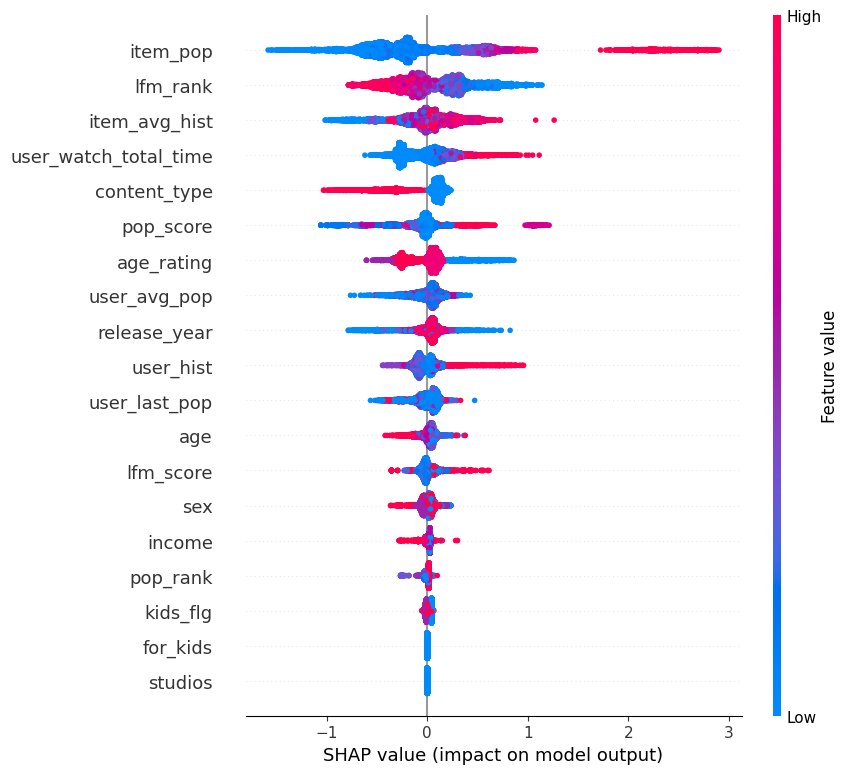

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

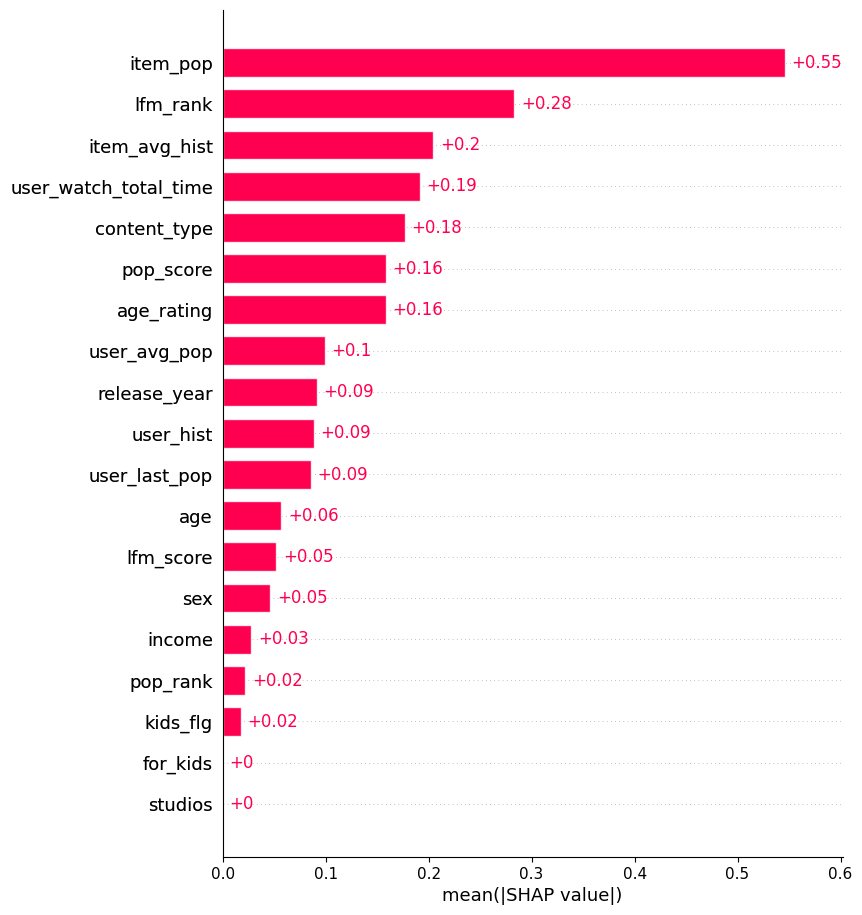

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

На графиках видно, что на модель сильно влияет популярность айтемов

In [ ]:
# Получаем предсказания для тестовых юзеров
y_pred: np.ndarray = pointwise_model.predict_proba(ranker_test[cols])[:, 1]
y_true: np.ndarray = np.array(ranker_test['target'])

y_pred

array([0.00093477, 0.01678507, 0.00110431, ..., 0.07390648, 0.00091535,
       0.00655863])

In [2]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    # Исключаем айтемы, которые не были предсказаны на первом уровне
    mask = (df['lfm_rank'] < 51).to_numpy()
    # Добавляем общий скор двухэтапной модели
    eps: float = 0.001
    min_score: float = min(y_pred_scores) - eps
    df[f'{name}_hybrid_score'] = df[f'{name}_score'] * mask
    df[f'{name}_hybrid_score'].replace(
        0,
        min_score,
        inplace=True,
    )
    # Добавляем общий ранг двухэтапной модели
    df[f'{name}_hybrid_rank'] = df[f'{name}_rank'] * mask
    max_rank: int = 51
    df[f'{name}_hybrid_rank'].replace(
        0,
        max_rank,
        inplace=True,
    )
    return df

In [ ]:
ranker_test = add_score_and_rank(ranker_test, y_pred, 'pointwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target,pointwise_score,pointwise_rank,pointwise_hybrid_score,pointwise_hybrid_rank
31,53,9728,2021-07-01,0.0,0.0,-0.00063,1,6862.99,51.0,3,...,-1,18.0,-1,76978.0,11.165736,0,0.079152,1,0.079152,1
10,53,3734,2021-07-30,11529.0,100.0,-0.00063,4,50004.00,6.0,3,...,-1,16.0,-1,50004.0,12.134949,1,0.047505,2,0.047505,2
11,53,4151,2021-07-29,4302.0,13.0,-0.00063,2,69641.00,4.0,3,...,-1,18.0,-1,69641.0,10.807886,0,0.030876,3,0.030876,3


In [ ]:
# Считаем рок аук от sklearn (не усредненный по юзерам)
roc_auc_score(y_true, y_pred)  # Получилась ерунда

0.8539164430099778

In [ ]:
# усредненный рок аук по юзерам
# df должен быть отсортирован по user_id
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['pointwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score
    )
)

(0.8619384339405171, 0.8619384339405171)

In [ ]:
# Получим значения метрик, а так же
# вспомним, какие метрики были у LightFM и сравним их между собой. Что не так?
models_metrics['pointwise'] = calc_metrics_(ranker_test, 'pointwise_rank')
models_metrics['pointwise_hybrid'] = calc_metrics_(ranker_test, 'pointwise_hybrid_rank')

pd.DataFrame(models_metrics)[['lfm', 'pointwise', 'pointwise_hybrid']]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.024622,0.025568,0.025568
recall@10,0.082339,0.083625,0.083625
ndcg@10,0.031616,0.033892,0.033892
map@10,0.042710,0.046191,0.046191
novelty@10,3.137157,3.493958,3.493958


In [ ]:
# сохраним метрики, тк на еще одно обучение модет не хватить оперативной памяти
pd.DataFrame(models_metrics).to_csv(
    '/content/drive/MyDrive/recsys_course/models_metrics', index=False
)

### Pairwise/Listwise

In [ ]:
# загружаем метрики
models_metrics = pd.read_csv('/content/drive/MyDrive/recsys_course/models_metrics')

In [ ]:
models_metrics.rename(index={
    0: 'Precision@10',
    1: 'recall@10',
    2: 'ndcg@10',
    3: 'map@10',
    4: 'novelty@10',
}, inplace= True )

In [ ]:
models_metrics[['lfm', 'pointwise', 'pointwise_hybrid']]

,lfm,pointwise,pointwise_hybrid
Precision@10,0.024622,0.025568,0.025568
recall@10,0.082339,0.083625,0.083625
ndcg@10,0.031616,0.033892,0.033892
map@10,0.042710,0.046191,0.046191
novelty@10,3.137157,3.493958,3.493958


In [7]:
# Для обучения ранжированию нужно правильно сформировать группы.
# В нашем случае группа равна одному юзеру.
# Для LGBMRanker нужно задать отсортированный по юзерам (группам) датафрейм,
# для которого списком групп будет список из количества
# ранжируемых айтемов на каждого юзера (группу).

def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [8]:
# Добавим таргет посложнее

def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df[Columns.Weight] >= 15).astype(int)  # 'watched_pct'
    df['target_ranker'] += (df[Columns.Weight] >= 75).astype(int)
    return df

ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

ranker_train.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,user_last_pop,user_watch_total_time,content_type,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker
0,3,101,2021-07-01,0.0,0.0,8.651793e-07,44,6862.99,51.0,-1,...,2858.0,0.0,0,2019.0,-1,18.0,-1,9542.0,17.990673,0
1,3,142,2021-08-13,5892.0,100.0,1.606612e-06,7,35862.00,8.0,-1,...,2858.0,0.0,0,2020.0,-1,16.0,-1,35862.0,15.251464,2
2,3,657,2021-07-01,0.0,0.0,8.317857e-07,49,7157.00,48.0,-1,...,2858.0,0.0,0,2015.0,-1,18.0,-1,7157.0,23.835266,0


In [9]:
# В train и val можно удалить 'плохих' пользователей,
# Например тех у кого слишком много или мало просмотров или
# тех для которых нет достаточного количества рекомендаций от LightFM
# Тестовую группу не меняем

def filter_group(df: pd.DataFrame) -> pd.DataFrame:
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    groups_df = (
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        .rename(columns={'item_id': 'group_size'})
    )
    df = pd.merge(
        df,
        groups_df,
        how='left',
        on=['user_id']
    )
    # Удаляем группы, без достаточного числа просмотров/кандидатов
    df = df[df['group_size'] >= 50]

    # Колонка больше не нужна
    df.drop(columns=['group_size'], inplace=True)
    return df

def filter_interations(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["lfm_rank"] <= 50]

ranker_train = filter_group(ranker_train)
ranker_val = filter_group(ranker_val)
ranker_train = filter_interations(ranker_train)
ranker_val = filter_interations(ranker_val)
# ranker_test = filter_group(ranker_test)

In [10]:
# Убираем ненужные айдишники, временные метки и таргеты.
# Для обучения используются только cols:
cols = [
    'lfm_score', 'lfm_rank', 'pop_score', 'pop_rank', 'age', 'income', 'sex',
    'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'user_watch_total_time', 'content_type', 'release_year', 'for_kids',
    'age_rating', 'studios', 'item_pop', 'item_avg_hist',
]
# Из них категориальные:
cat_cols = [
    'age', 'income', 'sex', 'kids_flg',
    'content_type', 'for_kids', 'studios',
]

In [11]:
early_stopping_rounds = 32
params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}
fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.128719
[LightGBM] [Debug] init for col-wise cost 0.000019 seconds, init for row-wise cost 0.901430 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.456368 seconds.
You can set `force_row_wise=true` to remove the overhead.

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [ ]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.7521841462199584),
             ('ndcg@5', 0.7757901006635033),
             ('ndcg@10', 0.7949034644627618)])

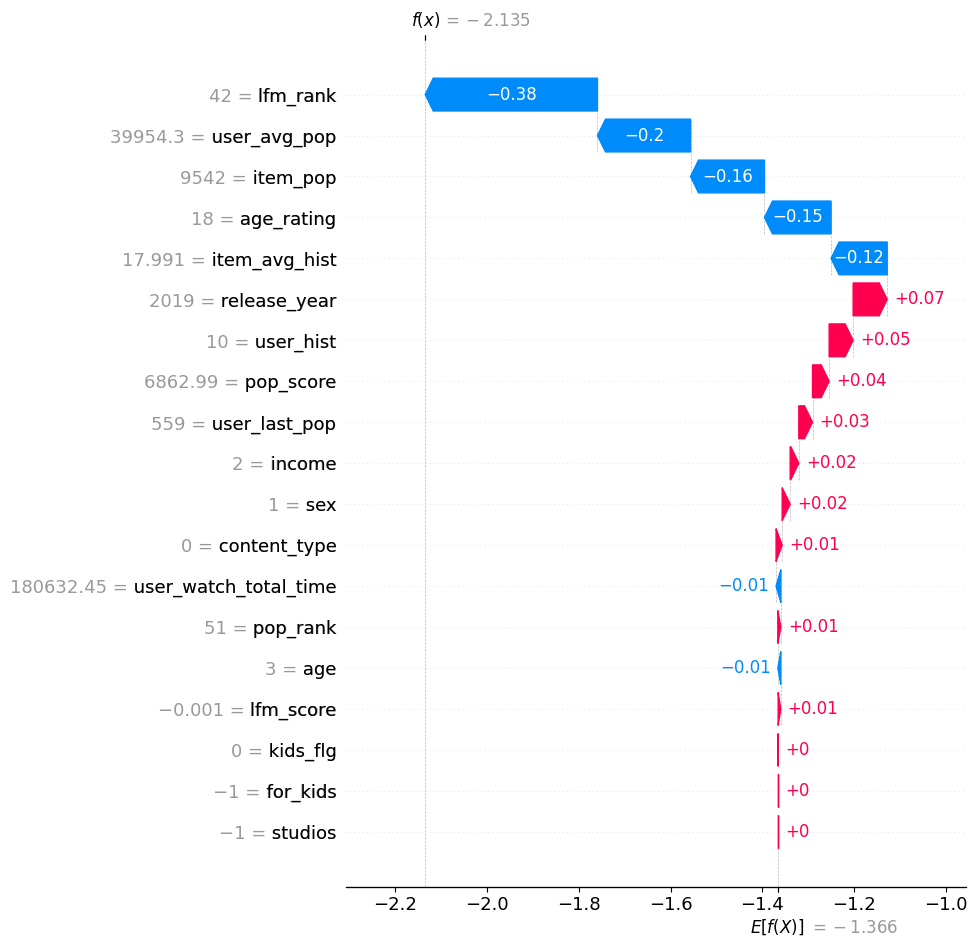

In [ ]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

shap.plots.waterfall(shap_values[0], max_display=len(cols))

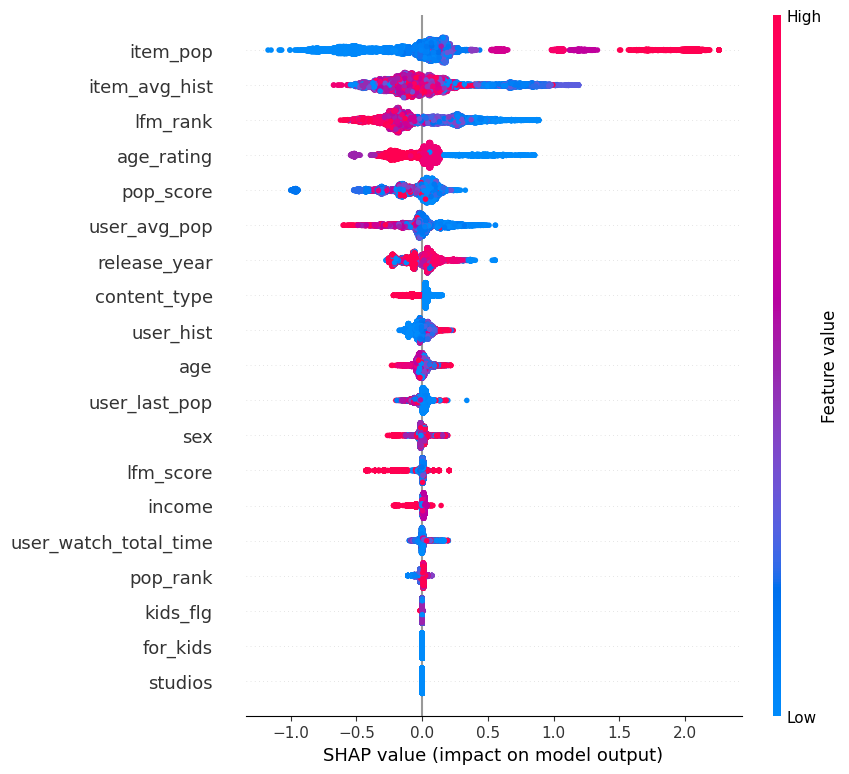

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

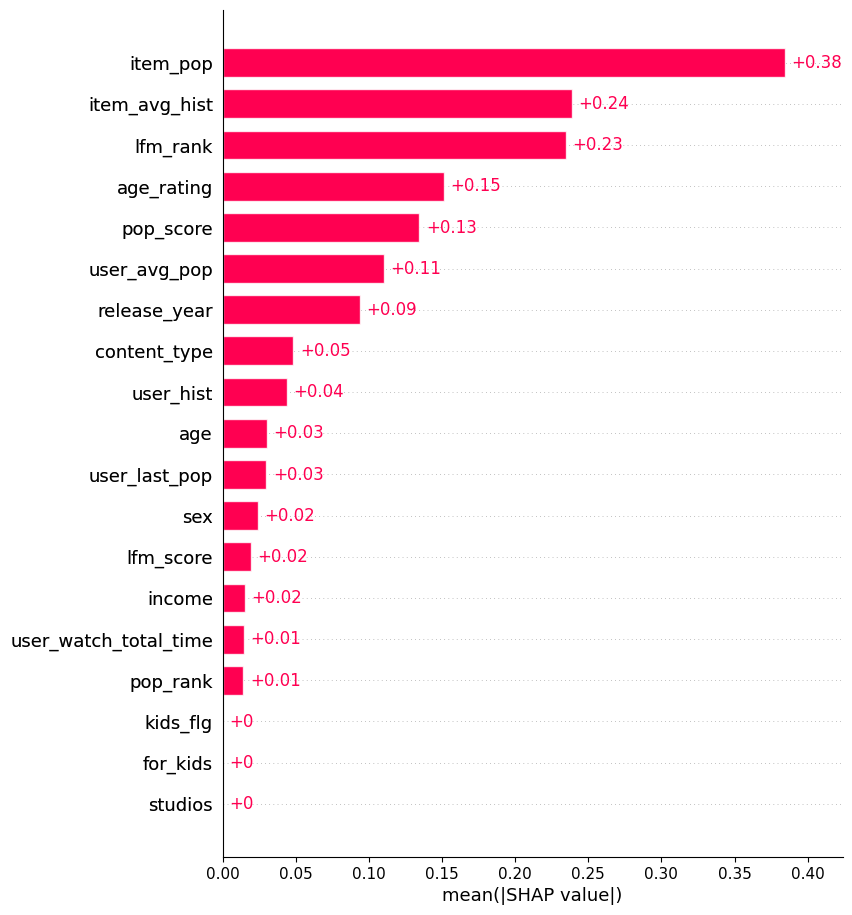

In [ ]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, y_pred, 'listwise')
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,for_kids,age_rating,studios,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
31,53,9728,2021-07-01,0.0,0.0,-0.000630,1,6862.99,51.0,3,...,-1,18.0,-1,76978.0,11.165736,0,1.739001,1,1.739001,1
10,53,3734,2021-07-30,11529.0,100.0,-0.000630,4,50004.00,6.0,3,...,-1,16.0,-1,50004.0,12.134949,2,1.108865,2,1.108865,2
37,53,12192,2021-07-01,0.0,0.0,-0.000631,20,14317.00,23.0,3,...,-1,16.0,-1,14317.0,13.140881,0,0.894616,3,0.894616,3


In [ ]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')
models_metrics['listwise_hybrid'] = calc_metrics_(ranker_test, 'listwise_hybrid_rank')
pd.DataFrame(models_metrics)[['listwise', 'listwise_hybrid']]

,listwise,listwise_hybrid
Precision@10,0.027773,0.027773
recall@10,0.092528,0.092528
ndcg@10,0.036135,0.036135
map@10,0.049687,0.049687
novelty@10,3.462423,3.462423


In [ ]:
(
    avg_user_metric(
        y_true=np.array(ranker_test['target']),  # target_ranker
        y_pred=np.array(ranker_test['listwise_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
    avg_user_metric(
        y_true=np.array(ranker_test['target']),
        y_pred=np.array(ranker_test['listwise_hybrid_score']),
        user_ids=np.array(ranker_test['user_id']),
        metric_function=roc_auc_score,
    ),
)

(0.8562679293431058, 0.8562679293431058)

## Итоговые метрики

In [ ]:
pd.DataFrame(models_metrics)[['lfm', 'pointwise_hybrid', 'listwise_hybrid']]

,lfm,pointwise_hybrid,listwise_hybrid
Precision@10,0.024622,0.025568,0.027773
recall@10,0.082339,0.083625,0.092528
ndcg@10,0.031616,0.033892,0.036135
map@10,0.042710,0.046191,0.049687
novelty@10,3.137157,3.493958,3.462423


По всем метрикам listwise-ранкер показал лучшие результаты. Получим из него рекомендации для сервиса.

In [6]:
MODELS_PATH = "/content/drive/MyDrive/recsys_course/models"

In [12]:
pickle.dump(listwise_model, open(f'{MODELS_PATH}/listwise_hybrid.pkl', "wb"))

## Получаем рекомендации для сервиса

In [3]:
# Загружаем данные
for name in ['train', 'val', 'test']:
    path: str = f'/content/drive/MyDrive/recsys_course/ranker_{name}.csv'
    locals()[f'ranker_{name}'] = pd.read_csv(path)

In [4]:
# Соберем данные в один датасет
ranker_full = pd.concat([ranker_train, ranker_val, ranker_test])
len(ranker_full)

9652450

In [7]:
# Загружаем модель-ранкер
listwise_model = pickle.load(open(f"{MODELS_PATH}/listwise_hybrid.pkl", "rb"))

In [10]:
# Делаем предсказания, проставляем ранги
y_pred: np.ndarray = listwise_model.predict(ranker_full[cols])
ranker_full = add_score_and_rank(ranker_full, y_pred, "listwise")
ranker_full.head()

,user_id,item_id,datetime,total_dur,weight,lfm_score,lfm_rank,pop_score,pop_rank,age,...,release_year,for_kids,age_rating,studios,item_pop,item_avg_hist,listwise_score,listwise_rank,listwise_hybrid_score,listwise_hybrid_rank
47,3,15297,2021-07-01,0.0,0.0,0.000003,1,137128.00,2.0,-1,...,2021.0,-1,18.0,-1,137128.0,7.364295,2.598634,1,2.598634,1
30,3,10440,2021-07-23,44827.0,90.0,0.000003,2,141889.00,1.0,-1,...,2021.0,-1,18.0,-1,141889.0,8.068716,1.715547,2,1.715547,2
28,3,9728,2021-07-23,10448.0,100.0,0.000002,4,6862.99,51.0,-1,...,2021.0,-1,18.0,-1,76978.0,11.165736,1.516541,3,1.516541,3
40,3,13865,2021-07-01,0.0,0.0,0.000002,3,93403.00,3.0,-1,...,2021.0,-1,12.0,-1,93403.0,10.408520,1.311493,4,1.311493,4
35,3,12192,2021-08-11,11499.0,15.0,0.000001,22,14317.00,23.0,-1,...,2019.0,-1,16.0,-1,14317.0,13.140881,0.586773,5,0.586773,5


In [11]:
# Ранжируем рекомендации
K_RECS = 10
ranker_full = ranker_full[[Columns.User, Columns.Item, "listwise_hybrid_rank"]]
# Выбираем топ-10 рекомендаций
ranker_full = (
    ranker_full.sort_values([Columns.User, "listwise_hybrid_rank"])
    .groupby(Columns.User)
    .head(K_RECS)
)
ranker_full.drop("listwise_hybrid_rank", axis=1, inplace=True)
ranker_full.head()

,user_id,item_id
47,3,15297
30,3,10440
28,3,9728
40,3,13865
35,3,12192


In [12]:
recos = ranker_full.groupby("user_id")["item_id"].agg(list).to_dict()

In [14]:
RECOS_PATH = "/content/drive/MyDrive/recsys_course/recommendations"

In [15]:
# сохраним рекомендации
with open(f"{RECOS_PATH}/listwise_ranker_recos.json", "w") as f:
    json.dump(recos, f)